# Práctica Spark
### TDM - Máster en IoT - Material original por Rafael Caballero, adaptada por Pablo C. Cañizares

Vamos a trabajar con datos de las evaluaciones Pisa por páises para tres disciplinas: ciencias (SCI), lectura (REA) y matemáticas (MAT). Los datos se han obtenido de: https://www.kaggle.com/zazueta/pisa-scores-2015


#### Setup

In [1]:
import os.path
from subprocess import check_call
import importlib
import os
import sys

modules = ["findspark", "pyspark"]


if "google.colab" in sys.modules:
    !apt-get install openjdk-8-jdk-headless -qq > /dev/null
    spark = "spark-3.2.0-bin-hadoop3.2.tgz"
    if not os.path.isfile(spark):
        !wget -q https://downloads.apache.org/spark/spark-3.2.0/{spark}
        !tar xf {spark}
        os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
        os.environ["SPARK_HOME"] = "/content/spark-3.2.0-bin-hadoop3.2"

print("Checking required modules")
for m in modules:
    torch_loader = importlib.util.find_spec(m)
    if torch_loader is not None:
        print(m, " found")
    else:
        print(m, " not found, installing")
        if "google.colab" in sys.modules:
            check_call(["pip", "install", "-q", m])
        else:
            check_call([sys.executable, "-m", "pip", "install", "--user", m])
print("Done!")
#!pip install -q findspark
#  !pip install -q pyspark
print("Ready!")

Checking required modules
findspark  found
pyspark  found
Done!
Ready!


In [2]:
pip install pyspark-dist-explore

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 2.8 MB/s eta 0:00:000:00:01m eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.7/12.7 MB 2.6 MB/s eta 0:00:002.6 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 2.2 MB/s eta 0:00:00m eta 0:00:010:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 2.4 MB/s eta 0:00:002.5 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 2.0 MB/s eta 0:00:002.1 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 2.9 MB/s eta 0:00:00 MB/s eta 0:00:01:01
Note: you may need to restart the kernel to use updated packages.


In [3]:
%matplotlib inline
import os

# cambiamos las variables del sistema
spark = "C:/hlocal/tdm/spark/spark-3.2.0-bin-hadoop3.2"
if not (os.path.isdir(spark + "/bin")) or not (os.path.isdir(spark + "/jars")):
    print("Error, la carpeta en 'spark' debe contener los directorios bin y jars ")
else:
    # en el path se añade
    # path = os.environ.get('PATH')
    # path = path+ ';'+spark+'\\bin;'
    # os.environ['PATH'] = path
    os.environ["SPARK_HOME"] = spark
    os.environ["HADOOP_HOME"] = spark
    os.environ["PYSPARK_DRIVER_PYTHON"] = "jupyter"
    os.environ["PYSPARK_DRIVER_PYTHON_OPTS"] = "notebook"

    # si da problema con collect quizás haya que poner java_home a la localización de java 8
    # os.environ['JAVA_HOME']= 'C:\\Program Files\\Java\\jdk1.8.0_151'
    # os.environ['PATH'] = os.environ.get('JAVA_HOME')+'\\bin;'+spark
    print("Hecho")
print("Preparado!!")


Error, la carpeta en 'spark' debe contener los directorios bin y jars 
Preparado!!


In [4]:
import findspark

findspark.init()

import pyspark  # only run after findspark.init()
from pyspark.sql import SparkSession

spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext


df = spark.sql("""select 'spark' as hola """)
df.show()

24/10/15 19:05:29 WARN Utils: Your hostname, ubuntu resolves to a loopback address: 127.0.1.1; using 10.9.14.88 instead (on interface wlp0s20f3)
24/10/15 19:05:29 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/10/15 19:05:30 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


+-----+
| hola|
+-----+
|spark|
+-----+



### Carga de datos
*1.* Cargar el fichero 'PisaData.csv', que contiene los resultados en las pruebas Pisa por países para los años 2013,2014,2015. 
Inicialmente lo cargamos como un RDD de texto, al que llamaremos raw_data




In [5]:
import urllib.request

url = "https://raw.githubusercontent.com/RafaelCaballero/tdm/master/datos/PisaData.csv"  # cambiar si está en otro lugarç
file = "./PisaData.csv"
f = urllib.request.urlretrieve(url, file)
raw_data = sc.textFile(file).cache()  # Un RDD de strings
raw_data.take(5)

['Country Name,Country Code,Series Name,Series Code,2013 [YR2013],2014 [YR2014],2015 [YR2015]',
 'Albania,ALB,PISA: Mean performance on the mathematics scale,LO.PISA.MAT,..,..,413.157',
 'Albania,ALB,PISA: Mean performance on the mathematics scale. Female,LO.PISA.MAT.FE,..,..,417.750029482799',
 'Albania,ALB,PISA: Mean performance on the mathematics scale. Male,LO.PISA.MAT.MA,..,..,408.545458736189',
 'Albania,ALB,PISA: Mean performance on the reading scale,LO.PISA.REA,..,..,405.2588']

24/10/15 19:05:50 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


### Preprocesamiento

Vemos algunas valores tienen '..' en lugar de un valor numérico. Se tratan de datos *missing*, es decir no conocidos, para algún año, asignatura y país. El problema de estos datos es que impedirían inferir que los campos son de tipo numérico.  Como en todo caso solo nos interesa el año 2015, lo primero que vamos a hacer es quedarnos con las columnas que nos interesan, y luego descartar, si los hay, los valores missing. Lo hacemos por fases

*2*  Utilizar una operación adecuado sobre RDDs que convierta el RDD en uno de arrays de strings, donde cada componente del array es un campo. Para ellos se debe separar cada línea por el carácter , (ver notebook SparkSQL). El resultado se llamara csv_data.

In [6]:
# solución
csv_data = raw_data.map(lambda x: x.split(","))

# para probar
csv_data.take(5)

[['Country Name',
  'Country Code',
  'Series Name',
  'Series Code',
  '2013 [YR2013]',
  '2014 [YR2014]',
  '2015 [YR2015]'],
 ['Albania',
  'ALB',
  'PISA: Mean performance on the mathematics scale',
  'LO.PISA.MAT',
  '..',
  '..',
  '413.157'],
 ['Albania',
  'ALB',
  'PISA: Mean performance on the mathematics scale. Female',
  'LO.PISA.MAT.FE',
  '..',
  '..',
  '417.750029482799'],
 ['Albania',
  'ALB',
  'PISA: Mean performance on the mathematics scale. Male',
  'LO.PISA.MAT.MA',
  '..',
  '..',
  '408.545458736189'],
 ['Albania',
  'ALB',
  'PISA: Mean performance on the reading scale',
  'LO.PISA.REA',
  '..',
  '..',
  '405.2588']]

**3** Solo nos interesan las columnas que ocupan las posiciones 0 (CountryName), 3 (Code) y 6 (YR2015). 
Escribir la operación sobre RDDs que crea a partir de csv_data un nuevo RDD, al que llamaremos datosRDD, que solo tiene estas columnas

Pista: Dada una fila l, queremos consutruir un nuevo array con los valores l[0],l[3] y l[6]

In [7]:
# solucion
datosRDD = csv_data.map(lambda x: [x[i] for i in (0, 3, 6)])

# Para probar
print(datosRDD.count())  # los mismos que csv_data:1167
datosRDD.take(5)

1167


[['Country Name', 'Series Code', '2015 [YR2015]'],
 ['Albania', 'LO.PISA.MAT', '413.157'],
 ['Albania', 'LO.PISA.MAT.FE', '417.750029482799'],
 ['Albania', 'LO.PISA.MAT.MA', '408.545458736189'],
 ['Albania', 'LO.PISA.REA', '405.2588']]

**4** Ahora quitamos los valores missing para la columna de índice 2. Es decir, quitamos aquellas filas cuyo valor en la columna 2 sea '..'.
El nuevo RDD se llamará *datosRDD2*

In [8]:
# Solucion
datosRDD2 = datosRDD.filter(lambda x: x[2] != "..")

print(datosRDD2.count())  # Quedan 582
datosRDD2.take(11)

582


[['Country Name', 'Series Code', '2015 [YR2015]'],
 ['Albania', 'LO.PISA.MAT', '413.157'],
 ['Albania', 'LO.PISA.MAT.FE', '417.750029482799'],
 ['Albania', 'LO.PISA.MAT.MA', '408.545458736189'],
 ['Albania', 'LO.PISA.REA', '405.2588'],
 ['Albania', 'LO.PISA.REA.FE', '434.639625546737'],
 ['Albania', 'LO.PISA.REA.MA', '375.75919916958'],
 ['Albania', 'LO.PISA.SCI', '427.225'],
 ['Albania', 'LO.PISA.SCI.FE', '439.442962901842'],
 ['Albania', 'LO.PISA.SCI.MA', '414.957643727778'],
 ['Algeria', 'LO.PISA.MAT', '359.6062']]



**5.** Cargar el fichero 'PisaDataBis.csv', que contiene los resultados en las pruebas Pisa por países para 2015. Utilizar el método 'fácil' que permite leer todo el fichero como una dataframe, infiriendo el esquema. Llamar al dataframe 'datos_df'

Nota: El fichero contiene cabeceras

In [9]:
# Utiliza el fichero PisaDataBis.csv'
# Cambiar si el path es diferente

# solucion; debe crear un dataframe datos
datos_df = spark.read.csv("PisaDataBis.csv", header=True, inferSchema=True)

print(datos_df.count())  # 63
datos_df.printSchema()
datos_df.take(5)


63
root
 |-- RPC: integer (nullable = true)
 |-- PAIS: string (nullable = true)
 |-- MAT: double (nullable = true)
 |-- MAT_FE: double (nullable = true)
 |-- MAT_MA: double (nullable = true)
 |-- REA: double (nullable = true)
 |-- REA_FE: double (nullable = true)
 |-- REA_MA: double (nullable = true)
 |-- SCI: double (nullable = true)
 |-- SCI_FE: double (nullable = true)
 |-- SCI_MA: double (nullable = true)



[Row(RPC=13274, PAIS='Albania', MAT=413.157, MAT_FE=417.7500295, MAT_MA=408.5454587, REA=405.2588, REA_FE=434.6396255, REA_MA=375.7591992, SCI=427.225, SCI_FE=439.4429629, SCI_MA=414.9576437),
 Row(RPC=15757, PAIS='Algeria', MAT=359.6062, MAT_FE=363.0724791, MAT_MA=356.4951057, REA=349.8593, REA_FE=366.2081668, REA_MA=335.1854359, SCI=375.7451, SCI_FE=383.2209389, SCI_MA=369.0352338),
 Row(RPC=21528, PAIS='Argentina', MAT=409.0333, MAT_FE=400.4431161, MAT_MA=418.3883609, REA=425.3031, REA_FE=432.9580796, REA_MA=416.9666072, SCI=432.2262, SCI_FE=424.9943513, SCI_MA=440.1020297),
 Row(RPC=52190, PAIS='Australia', MAT=493.8962, MAT_FE=490.9855008, MAT_MA=496.7613449, REA=502.9006, REA_FE=518.8657992, REA_MA=487.1855255, SCI=509.9939, SCI_FE=508.9216474, SCI_MA=511.0492572),
 Row(RPC=51936, PAIS='Austria', MAT=496.7423, MAT_FE=483.1330261, MAT_MA=510.0982159, REA=484.8656, REA_FE=495.0751911, REA_MA=474.8460316, SCI=495.0375, SCI_FE=485.5267543, SCI_MA=504.3711973)]

### Estadísticas básicas


**6** Dibujar el histograma correspondiente a la columna 'SCI' que da los datos globales en ciencias. Usar un gráfico de 23 barras en azul.


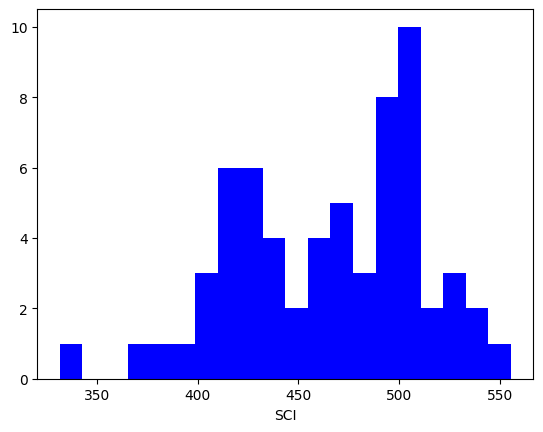

In [17]:
%matplotlib inline
from pyspark_dist_explore import hist
import matplotlib.pyplot as plt

# solucion
fig, ax = plt.subplots()
col = "SCI"
hist(ax, datos_df.select([col]), bins=20, color=["blue"])
plt.xlabel(col)
plt.show()

**7** Observamos algo curioso: la gráfica parece tener varios 'picos' (¿varias normales superpuestas?). 
    Escribir una instrucción en SPARKSQL que nos devuelva un dataframe los países que están por debajo de 450. 
    El nuevo dataframe recibirá como nombre menor_df. 
    
    Utilizar una instrucción filter de SPARK SQL, seguida de un select para tomar solo la columna país (y SCI)
    
    https://stackoverflow.com/questions/45978108/multiple-condition-filter-on-dataframe

In [18]:
# solución
menor_df = datos_df.filter(datos_df.SCI < 450).select("PAIS", "SCI")

# quitar comentario para probar
menor_df.show()

+-------------------+--------+
|               PAIS|     SCI|
+-------------------+--------+
|            Albania| 427.225|
|            Algeria|375.7451|
|          Argentina|432.2262|
|             Brazil|400.6821|
|         Costa Rica| 419.608|
|             Cyprus|432.5964|
|             Mexico|415.7099|
|         Montenegro|411.3136|
|               Peru|396.6836|
|           Thailand|421.3373|
|Trinidad and Tobago|424.5905|
|            Tunisia|386.4034|
|            Uruguay| 435.363|
|           Bulgaria| 445.772|
|              Chile|446.9561|
|           Colombia|415.7288|
| Dominican Republic|331.6388|
|            Georgia|411.1315|
|          Indonesia|403.0997|
|             Jordan|408.6691|
+-------------------+--------+
only showing top 20 rows



 **8** Número de países en los que las mujeres son peores en lectura que los hombres (REA_FE > REA_MA)
 
 Ayuda: El resultado es ¡0!

In [24]:
# solución
datos_df.filter(datos_df.REA_FE < datos_df.REA_MA).count()

0


Vemos que corresponden a países con renta per capita no muy alta. Digamos que el histograma muestra las diferencias en renta

**9**  ¿Es la correlación entre SCI (columna 7 de datos_df) y MAT (columna 1) es mayor que la correlación entre SCI y REA (columna 4)?. Mostrar ambos valores. Ayuda: Ver SparkSQL, justo antes de 'muestras'

In [29]:
from pyspark.sql.functions import corr
import math

# solución

sci_mat = datos_df.select(corr("SCI", "MAT")).collect()
sci_rea = datos_df.select(corr("SCI", "REA")).collect()

print("corr. sci-mat: ", sci_mat, " corr. sci-rea: ", sci_rea)


corr. sci-mat:  [Row(corr(SCI, MAT)=0.9750789667836628)]  corr. sci-rea:  [Row(corr(SCI, REA)=0.9647546354911346)]


**10** Queremos saber qué decil ocupa españa en ciencias (SCI). Para ello

1. Obtendremos el valor de españa en ciencias
2. Calcularemos los deciles de la columna sci con la función approxQuantile (sobre la que debemos buscar información en internet). Usar como cota del error el valor 0.
3. Mostraremos el decil por pantalla (D1 si está en el mejor 10%, D2 si está en el top 20%, y así hasta D10 si está en el peor 10%)

In [76]:
# solución
spain_decile = datos_df.filter(datos_df.PAIS == "Spain").first().SCI
print(spain_decile)

deciles = datos_df.approxQuantile("SCI", [x / 10 for x in range(1, 10)], 0)
print(deciles, spain_decile)

for i, decile in enumerate(reversed(deciles)):
    if spain_decile > decile:
        print(f"D{i + 1}")
        break

492.7861
[408.6691, 419.608, 432.2262, 454.8288, 475.3912, 490.225, 498.4811, 505.5058, 513.3035] 492.7861
D4
